In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import csv

In [2]:
N_WAVELENGTH = 228
LOD_URE = 1000


In [3]:
df_train = pd.read_csv("data_NIRS/Merged_db.csv").drop_duplicates()

columns_wl = {}
for i, col in enumerate(df_train.columns[-N_WAVELENGTH:]):
    columns_wl[col] = str(i+1)
    
df_train.rename(columns=columns_wl, inplace=True)
df_train.head()

,Mã NIR,Urea,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,...,219,220,221,222,223,224,225,226,227,228
0,2113099a1,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",1,Hadamard 1,...,-0.136101,-0.287185,-0.380416,-0.459176,-0.407652,-0.472400,-0.429911,-0.333819,-0.395731,-0.167501
1,2113099a2,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",2,Hadamard 1,...,-0.135012,-0.306666,-0.467668,-0.492477,-0.481871,-0.370628,-0.297349,-0.409274,-0.486664,-0.426964
2,2113099a3,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",3,Hadamard 1,...,-0.324308,-0.427586,-0.539696,-0.547557,-0.575114,-0.555003,-0.462344,-0.440240,-0.298107,-0.313747
3,2113099a4,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",4,Hadamard 1,...,-0.298622,-0.377505,-0.534373,-0.577949,-0.533663,-0.570596,-0.488621,-0.419825,-0.354021,-0.295377
4,2113099a5,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",5,Hadamard 1,...,-0.272732,-0.429970,-0.496265,-0.559068,-0.586745,-0.516311,-0.469121,-0.351306,-0.360435,-0.257529


In [4]:
df_test = pd.read_csv("data_NIRS/merged_Ure_NEW.csv").drop_duplicates()

columns_wl = {}
for i, col in enumerate(df_test.columns[-N_WAVELENGTH:]):
    columns_wl[col] = str(i+1)
    
df_test.rename(columns=columns_wl, inplace=True)
df_test.head()

,Mã mẫu NIRS,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,Vị trí đo,Lần lặp,Phương pháp đo,Ngày đo,Giờ đo,...,219,220,221,222,223,224,225,226,227,228
0,2111568a1,Đà Nẵng,Ure,Nục 1,Chợ,"Ngoài da, gáy",1,Hadamard,11/5/2023,8:09:51,...,1.138632,1.086649,1.072406,1.046379,1.028282,1.041812,1.078732,1.046972,1.049573,1.100763
1,2111568a2,Đà Nẵng,Ure,Nục 1,Chợ,"Ngoài da, gáy",2,Hadamard,11/5/2023,8:10:26,...,1.260991,1.218730,1.195620,1.161806,1.154972,1.133565,1.168082,1.176639,1.174512,1.230493
2,2111568a3,Đà Nẵng,Ure,Nục 1,Chợ,"Ngoài da, gáy",3,Hadamard,11/5/2023,8:11:05,...,1.062865,1.072660,0.978477,1.001597,0.966198,0.918461,0.949064,1.102628,1.049141,0.851952
3,2111568a4,Đà Nẵng,Ure,Nục 1,Chợ,"Ngoài da, gáy",4,Hadamard,11/5/2023,8:11:15,...,1.066745,1.014306,1.010373,0.954488,0.969100,0.974906,1.108055,0.903741,0.947161,1.233467
4,2111568a5,Đà Nẵng,Ure,Nục 1,Chợ,"Ngoài da, gáy",5,Hadamard,11/5/2023,8:11:58,...,1.030767,0.992682,0.966131,0.919204,0.899133,0.904584,0.924729,0.864697,0.982009,1.062379


# Xử lý dữ liệu NaN và vô hạn

In [5]:
def handle_invalid_data(df):
    print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
    print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')
    
    null_check = df.isna()
    indices_null = np.argwhere(null_check.to_numpy() == True)

    inf_check = np.isinf(df.iloc[:,-N_WAVELENGTH:])
    indices_inf = np.argwhere(inf_check.to_numpy()== True)
    indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

    indices = np.concatenate((indices_inf, indices_null))
    
    n_nearest = 5 # Sử dụng n giá trị gần nhất cả 5 phía trước và sau để tính mean của missing data
    for x,y in indices:
        try:
            if y < df.shape[1] - N_WAVELENGTH: 
                continue
            left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
            right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
            # sample = left.combine_first(right)
            sample = pd.concat([left, right], axis=1)
            df.iloc[x, y] = np.mean(sample)
        except:
            print(x,y)
            df.drop(x, inplace = True)
    print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
    print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')
    return df

In [6]:
df_train = handle_invalid_data(df_train)

Tổng các điểm dữ liệu trống trước xử lý: 0
Tổng các điểm dữ liệu vô hạn trước xử lý: 0
Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


In [7]:
print(df_test.shape)
df_test = handle_invalid_data(df_test)
print(df_test.shape)

(4400, 242)
Tổng các điểm dữ liệu trống trước xử lý: 319
Tổng các điểm dữ liệu vô hạn trước xử lý: 17
3322 14
Tổng các điểm dữ liệu trống sau xử lý: 107
Tổng các điểm dữ liệu vô hạn sau xử lý: 0
(4399, 242)


In [8]:
print(df_test.shape)
df_test = handle_invalid_data(df_test)
print(df_test.shape)

(4399, 242)
Tổng các điểm dữ liệu trống trước xử lý: 107
Tổng các điểm dữ liệu vô hạn trước xử lý: 0
Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0
(4399, 242)


# Thống kê dữ liệu

In [54]:
df_test['Loại cá'].value_counts()

Loại cá
Ngừ 1    1200
Thu 2    1200
Thu 1    1199
Nục 1     800
Name: count, dtype: int64

In [10]:
df_train['Loại cá'].value_counts()

Loại cá
Nục 2    3425
Ngừ 1    3120
Thu 1    1545
Nục 1     360
Name: count, dtype: int64

In [11]:
df_test['Địa điểm lấy mẫu'].value_counts()

Địa điểm lấy mẫu
Cảng cá    3599
Chợ         800
Name: count, dtype: int64

In [55]:
4399-480


3919

In [53]:
for location in list(df_test['Địa điểm lấy mẫu'].unique()):
    sub_df_test = df_test[df_test['Địa điểm lấy mẫu'] == location]
    print(location, sub_df_test['Loại cá'].value_counts())

Chợ Loại cá
Nục 1    800
Name: count, dtype: int64
Cảng cá Loại cá
Ngừ 1    1200
Thu 2    1200
Thu 1    1199
Name: count, dtype: int64


In [12]:
df_train['Địa điểm lấy mẫu'].value_counts()

Địa điểm lấy mẫu
Cảng cá    8450
Name: count, dtype: int64

In [13]:
for type_fish in list(df_train['Loại cá'].unique()):
    sub_df = df_train[df_train['Loại cá'] == type_fish]
    encode_target = np.where(sub_df['Urea'] > LOD_URE, 1, 0)
    count_target = np.unique(encode_target, return_counts=True)
    fish_number = len(sub_df['STT mẫu cá'].unique())
    print(type_fish, count_target, fish_number)

Nục 1 (array([1]), array([360], dtype=int64)) 6
Nục 2 (array([0, 1]), array([2405, 1020], dtype=int64)) 57
Ngừ 1 (array([0, 1]), array([2760,  360], dtype=int64)) 52
Thu 1 (array([0, 1]), array([1185,  360], dtype=int64)) 26


In [14]:
for type_fish in list(df_test['Loại cá'].unique()):
    sub_df = df_test[df_test['Loại cá'] == type_fish]
    encode_target = np.where(sub_df['Urea'] > LOD_URE, 1, 0)
    count_target = np.unique(encode_target, return_counts=True)
    fish_number = len(sub_df['Mã mẫu cá'].unique())
    print(type_fish, count_target, fish_number)

Nục 1 (array([0, 1]), array([720,  80], dtype=int64)) 20
Ngừ 1 (array([0, 1]), array([800, 400], dtype=int64)) 30
Thu 2 (array([0]), array([1200], dtype=int64)) 30
Thu 1 (array([0]), array([1199], dtype=int64)) 30


# Chia dữ liệu Train và trực quan trước khi SMOTE

In [15]:
X_TRAIN = df_train.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = np.where(df_train['Urea'] > LOD_URE, 1, 0)

Text(0.5, 1.0, 'Label Percentage(%) after SMOTE')

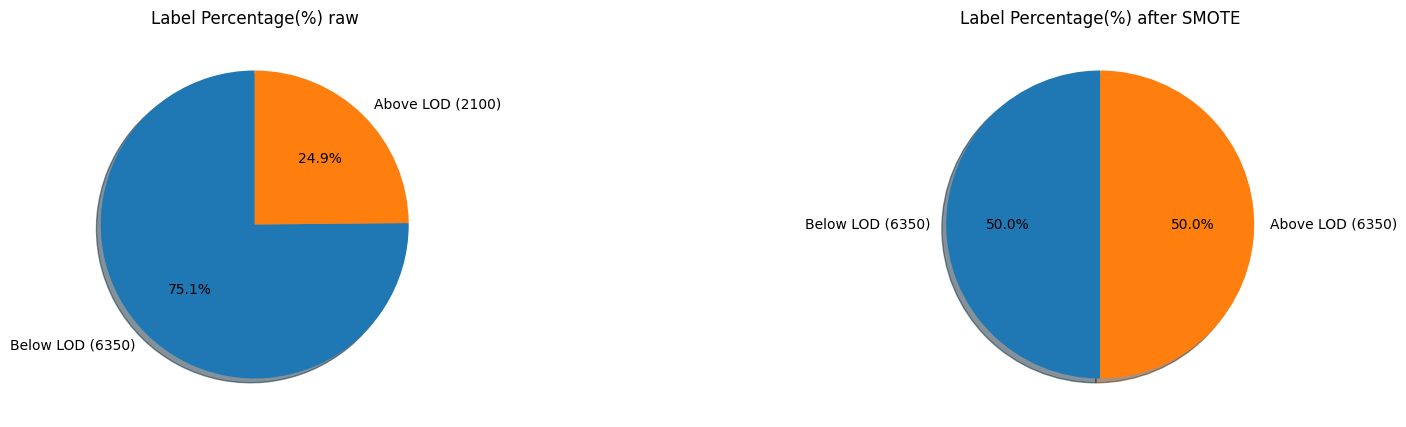

In [16]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
X_TRAIN_SMOTE, Y_TRAIN_SMOTE = over_sample.fit_resample(X_TRAIN, Y_TRAIN)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

y_train_smote = np.unique(Y_TRAIN_SMOTE, return_counts = True)
y_train_raw = np.unique(Y_TRAIN, return_counts = True)

axes[0].pie(y_train_raw[1], labels=[f'Below LOD ({y_train_raw[1][0]})', f'Above LOD ({y_train_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%) raw')

axes[1].pie(y_train_smote[1], labels=[f'Below LOD ({y_train_smote[1][0]})', f'Above LOD ({y_train_smote[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%) after SMOTE')

Chia dữ liệu TEST (không dùng SMOTE)

Text(0.5, 1.0, 'Count of label')

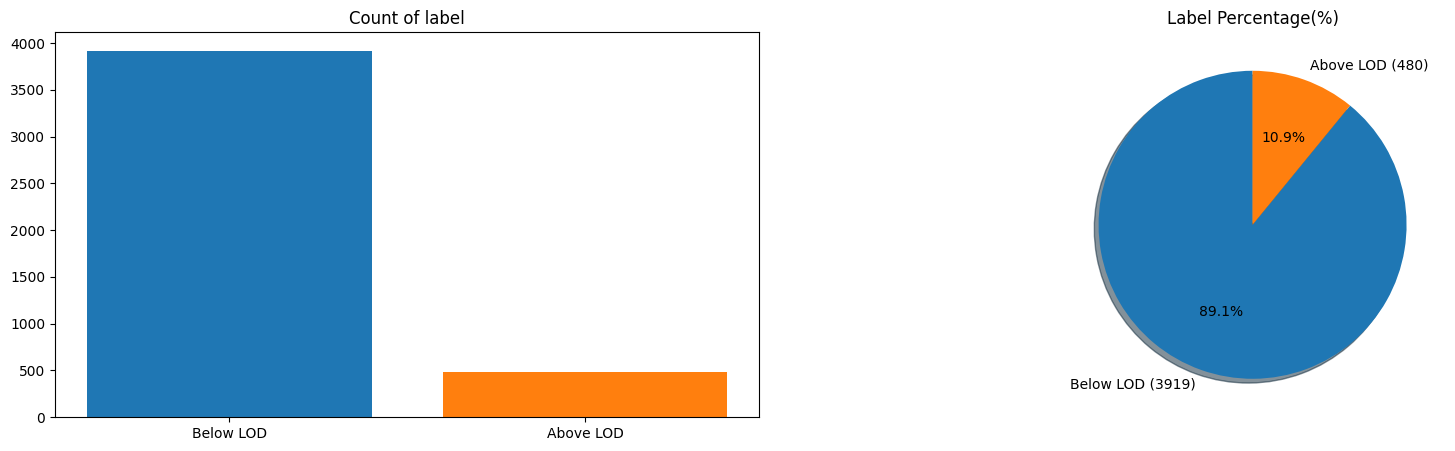

In [47]:
X_TEST = df_test.iloc[:,-N_WAVELENGTH:]
Y_TEST = np.where(df_test['Urea'] >= LOD_URE, 1, 0)
y_test_raw = np.unique(Y_TEST, return_counts = True)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[1].pie(y_test_raw[1], labels=[f'Below LOD ({y_test_raw[1][0]})', f'Above LOD ({y_test_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(y_test_raw[0], y_test_raw[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

# Tiền xử lý

Savizky-Golay 

In [18]:
def my_SG(X, deriv=0):
    return savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)

In [19]:
def snv(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


In [20]:
def my_preprocess_data(X_data, feature='sg0', normalization = 'msc'):
    X_data_prep = X_data

    if normalization == 'msc':
        X_data_prep = msc(X_data)
    elif normalization == 'snv':
        X_data_prep = snv(X_data)
    elif normalization == 'minmax':
        X_data_prep = my_MinMaxScaler(X_data)
    elif normalization == 'robust':
        X_data_prep = my_RobustScaler(X_data)
        
    if feature == 'sg0':
        X_data_prep = my_SG(X_data_prep, 0)
    elif feature == 'sg1':
        X_data_prep = my_SG(X_data_prep, 1)
    elif feature == 'sg2':
        X_data_prep = my_SG(X_data_prep, 2)
    elif feature == 'sg1 + sg2':
        X_data_SG1 = my_SG(X_data_prep, 1)
        X_data_SG2 = my_SG(X_data_prep, 2)
        X_data_prep = np.hstack([X_data_SG1, X_data_SG2])
        
    return X_data_prep

# chọn các đặt trưng tối ưu

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def get_optimal_wavelength(X, y, top_n_features=10):
    best_features = SelectKBest(score_func=f_classif, k=top_n_features)
    fit = best_features.fit(X, y)

    return list(fit.get_feature_names_out())

In [22]:
# dữ liệu train và test đã dùng SMOTE
X_DATA = pd.concat([X_TRAIN_SMOTE, X_TEST], axis=0)
Y_DATA = np.hstack((Y_TRAIN_SMOTE, Y_TEST))

In [23]:
def get_list_wl_for_data_preprocessed(x_data, y_data):
    result = []
    
    length_wl = x_data.shape[1]
    start = int(length_wl*0.2)
    step = int(length_wl*0.1)
    
    for n_wl in range(start, length_wl, step):
        n_wavelength = get_optimal_wavelength(x_data, y_data, n_wl)
        n_wavelength = [int(re.findall(r'\d+', i)[0]) for i in n_wavelength]
        result.append(n_wavelength)
    return result

In [24]:
def get_list_wl(x_data, y_data):
    result = []
    
    length_wl = x_data.shape[1]
    start = int(length_wl*0.2)
    step = int(length_wl*0.1)
    
    for n_wl in range(start, length_wl, step):
        n_wavelength = get_optimal_wavelength(x_data, y_data, n_wl)
        n_wavelength = [int(i) - 1 for i in n_wavelength]
        result.append(n_wavelength)
    return result

# SVM

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [58]:
best_acc_svm = 0
best_c = 0
best_kernel = ''

for kernel in ['linear', 'rbf']:
    for c in range(-3,4):
        svc = SVC(kernel=kernel, C=10**int(c)) 
        svc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
        y_pred = svc.predict(X_TEST)
        acc = accuracy_score(Y_TEST, y_pred)
        
        if acc > best_acc_svm:
            best_acc_svm = acc
            best_c = 10**int(c)
            best_kernel = kernel

In [59]:
print(f'kernel: {best_kernel}, C: {best_c} => accuracy: {best_acc_svm}')

kernel: rbf, C: 0.001 => accuracy: 0.8908842918845192


In [28]:
def my_SVM(X_train, y_train, X_test, y_test):

    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [34]:
test_max_acc = 0
test_wl_optimal_svm = []
for n_wavelength in get_list_wl(X_DATA, Y_DATA):
    acc = my_SVM(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE, X_TEST.iloc[:,n_wavelength], Y_TEST)
    if acc > test_max_acc:
        max_acc = acc
        test_wl_optimal_svm = n_wavelength
print(test_max_acc, len(test_wl_optimal_svm))

0 221


In [36]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']


acc_svm0 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = my_preprocess_data(X_TRAIN_SMOTE.iloc[:,test_wl_optimal_svm],  feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST.iloc[:,test_wl_optimal_svm], feature=feature, normalization=normal)
        
        acc = my_SVM(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)

        print(acc)
        acc_svm0.append(acc)


11.025
36.303999999999995
41.782000000000004
49.057
13.48
59.377
59.763999999999996
58.467999999999996
16.367
63.242
63.742
62.241
13.866999999999999
60.036
60.241
59.218


In [29]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

list_wl_optimal_svm = []
acc_svm = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = my_preprocess_data(X_TRAIN_SMOTE,feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST,feature=feature, normalization=normal)
        
        max_acc = 0
        wl_optimal_svm = []
        for n_wavelength in get_list_wl_for_data_preprocessed(np.vstack((X_train, X_test)), np.hstack((Y_TRAIN_SMOTE, Y_TEST))):
            acc = my_SVM(X_train[:,n_wavelength], Y_TRAIN_SMOTE, X_test[:,n_wavelength], Y_TEST)
            if acc > max_acc:
                max_acc = acc
                wl_optimal_svm = n_wavelength
 
        print(max_acc, len(wl_optimal_svm))
        acc_svm.append(max_acc)
        list_wl_optimal_svm.append(wl_optimal_svm)

89.066 45
52.171 45
47.488 45
50.011 45
89.02 45
62.332 45
61.673 67
60.331999999999994 45
82.837 45
75.608 45
73.789 45
72.38 45
88.907 91
63.12799999999999 91
62.742 91
60.809000000000005 136


In [30]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_svm2 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = my_preprocess_data(X_TRAIN_SMOTE,feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST,feature=feature, normalization=normal)
        
        max_acc = 0
        wl_optimal_svm = []
        acc = my_SVM(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
 
        print(acc)
        acc_svm2.append(acc)

10.979999999999999
34.144000000000005
41.282000000000004
46.623999999999995
13.526
59.241
59.423
58.445
16.049
63.196
63.674
62.355000000000004
13.844000000000001
59.785999999999994
59.923
59.059


In [44]:
X_train = my_preprocess_data(X_TRAIN_SMOTE,feature='sg0', normalization='msc')
X_test = my_preprocess_data(X_TEST,feature='sg0', normalization='msc')

svc = SVC(kernel=best_kernel, C=best_c) 
svc.fit(X_train[:,list_wl_optimal_svm[0]], Y_TRAIN_SMOTE)
y_pred = svc.predict(X_test[:,list_wl_optimal_svm[0]])
acc = np.round(accuracy_score(Y_TEST, y_pred),5)*100
confuse_matrix = metrics.confusion_matrix(Y_TEST, y_pred)
print(acc)
print(confuse_matrix)

89.066
[[3918    1]
 [ 480    0]]


<Axes: >

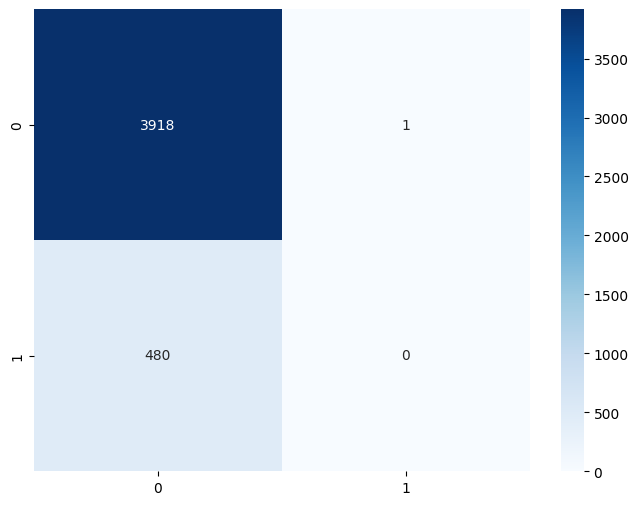

In [56]:
import seaborn as sn
plt.figure(figsize = (8,6))
df_cm = pd.DataFrame(confuse_matrix, range(2), range(2))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

# Sử dụng mô hình SVM đo các vị trí của cá

In [41]:
accuracy_each_position = []
confuse_matrix_each_position = []

X_train = my_preprocess_data(X_TRAIN_SMOTE, feature='sg0', normalization='msc')
svc = SVC(kernel=best_kernel, C=best_c) 
svc.fit(X_train[:,list_wl_optimal_svm[0]], Y_TRAIN_SMOTE)

for position in list(df_test['Vị trí đo'].unique()):
    sub_data_TEST = df_test[df_test['Vị trí đo'] == position]
    sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]

    sub_X_TEST_prep = my_preprocess_data(sub_X_TEST, feature='sg0', normalization='msc')
    sub_Y_TEST = np.where(sub_data_TEST['Urea'] > LOD_URE, 1, 0)
    
    y_pred = svc.predict(sub_X_TEST_prep[:,list_wl_optimal_svm[0]])
    acc_svm = accuracy_score(sub_Y_TEST, y_pred)
    
    accuracy_each_position.append(acc_svm)
    confuse_matrix_each_position.append(metrics.confusion_matrix(sub_Y_TEST, y_pred))
    
    print(f'Vị trí : {position}  ==>  độ chính xác: {acc_svm}')
    
print('='*40)

Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.8907103825136612
Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.8909090909090909
Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.8907103825136612
Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.8911070780399274
Vị trí : Trong thịt, gáy  ==>  độ chính xác: 0.8920863309352518
Vị trí : Trong thịt, lưng  ==>  độ chính xác: 0.8909090909090909
Vị trí : Trong thịt, đuôi  ==>  độ chính xác: 0.8907103825136612
Vị trí : Trong thịt, bụng  ==>  độ chính xác: 0.8899082568807339


In [43]:
for i in confuse_matrix_each_position:
    print(i)
    print('---------')

[[489   0]
 [ 60   0]]
---------
[[490   0]
 [ 60   0]]
---------
[[489   0]
 [ 60   0]]
---------
[[491   0]
 [ 60   0]]
---------
[[496   0]
 [ 60   0]]
---------
[[490   0]
 [ 60   0]]
---------
[[489   0]
 [ 60   0]]
---------
[[485   0]
 [ 60   0]]
---------


In [ ]:
confuse_matrix = []
for i in range(K_FOLD):
    matrix = list_confuse_matrix_cv_SVM[i][1]
    confuse_matrix.append(np.array(matrix))
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][1]
    fn = matrix[1][0]
    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    f1_score = (2*precision*recall)/(precision + recall)